# Libraries

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from pathlib import Path
import sys

root = str(Path().resolve().parent)
if root not in sys.path:
    sys.path.append(root)
print(*sys.path, sep="\n")

# %matplotlib ipympl
%matplotlib inline

/usr/lib/python312.zip
/usr/lib/python3.12
/usr/lib/python3.12/lib-dynload

/home/ryanwtsai/repos/rfdsp_sim/python/venv/lib/python3.12/site-packages
/home/ryanwtsai/repos/rfdsp_sim/python


In [77]:
from importlib import reload
from rfdsppy import calc, ofdm, rf_analog, rf_tx_fw, tonegen, rf_estimation as rf_est

reload(calc)
reload(ofdm)
reload(rf_analog)
reload(rf_tx_fw)
reload(tonegen)
reload(rf_est)

<module 'rfdsppy.rf_estimation' from '/home/ryanwtsai/repos/rfdsp_sim/python/rfdsppy/rf_estimation.py'>

# Phase Noise

In [113]:
modorder = 64
bw = 20
scs = 15
num_sc = 1200
start_sc = 600-round(num_sc/2)
en_tprecode = True
osr = 4
wola = 1
ofdm_wavgen = ofdm.OFDMWavGen(bw, scs, modorder, start_sc, num_sc=num_sc, en_tprecode=en_tprecode, osr=osr, wola=wola)

x, x_standard = ofdm_wavgen.generate(14*3)
cfg = ofdm_wavgen.get_demod_params()
fs = cfg.get("fs")

pn = rf_analog.PhaseNoise(-95, -150, 100/1000, 1/1000, fs)

y = pn.transform(x)

IPN (dBc) = -42.95725751753534


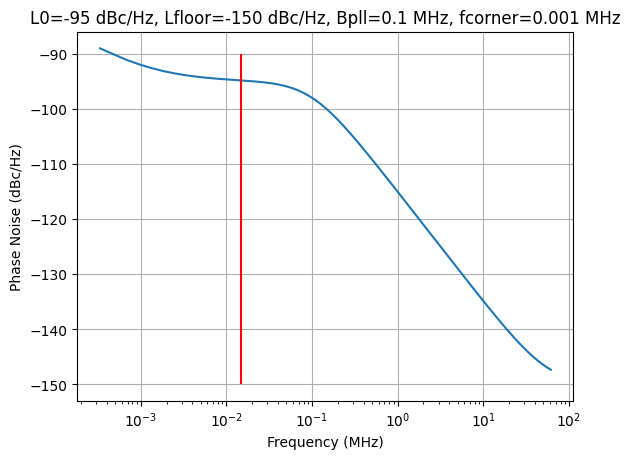

In [114]:
fig, ax = pn.plot()
ax.vlines([scs/1000], ymin=-150, ymax=-90, colors='r')
IPN = pn.calculate_ipn(fmin=1/1000, fmax=10)
print(f"IPN (dBc) = {IPN}")

EVM: 0.73%
SNR: 42.718712192636346
0.7184428175107554
-42.872155852691506


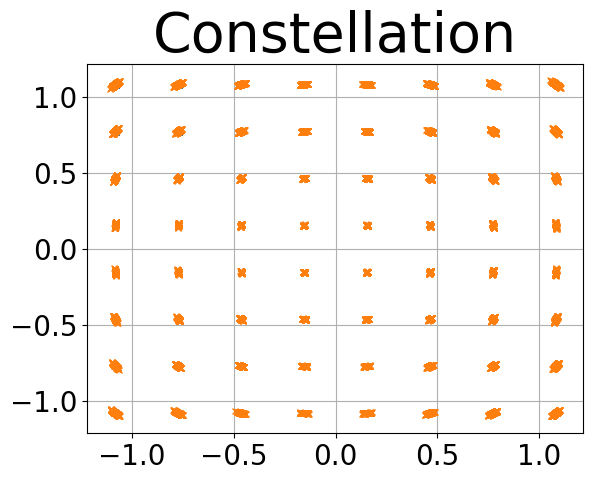

In [115]:
evm = ofdm_wavgen.calculate_evm(x_standard, y[round(cfg["wola_len"]/2):], en_plot=True, en_fd_eq=False)
print(f"EVM: {evm.round(2)}%")
print(f"SNR: {-20*np.log10(evm/100)}")
print(calc.rms(pn.theta_)*100)
print(20*np.log10(calc.rms(pn.theta_)))

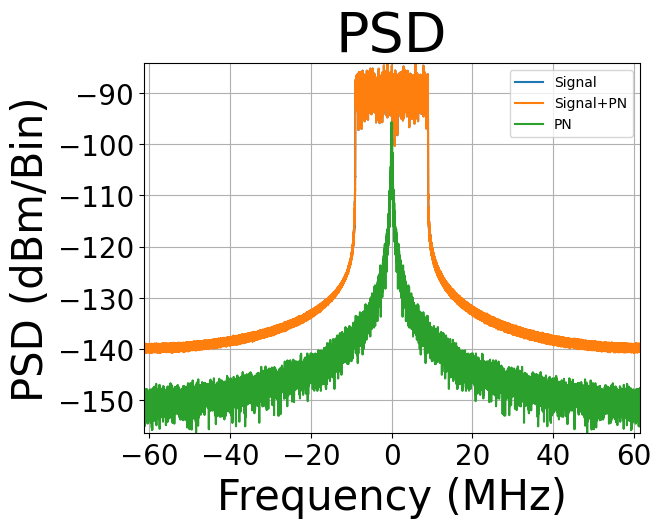

In [68]:
fs = cfg.get("fs")
rbw = scs/1000/2**2

py, f = calc.psd(y, fs, rbw)
px, _ = calc.psd(x, fs, rbw)
pz, _ = calc.psd(pn.theta_, fs, rbw)
# py = calc.scale_psd(py, f, bw, scs, start_sc, num_sc)
# px = calc.scale_psd(px, f, bw, scs, start_sc, num_sc)

fig = plt.figure()
plt.plot(f, 10*np.log10(px), label="Signal")
plt.plot(f, 10*np.log10(py), label="Signal+PN")
plt.plot(f, 10*np.log10(pz), label="PN")
plt.title("PSD", {'fontsize':40})
plt.xlabel("Frequency (MHz)", {'fontsize':30})
plt.ylabel("PSD (dBm/Bin)", {'fontsize':30})
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.autoscale(enable=True, axis='both', tight=True)
plt.legend(loc="best")
plt.grid()